In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sb

In [2]:
import json

with open('anaconda_projects/db/watch-history.json','r',encoding='utf-8') as f:
    data = json.load(f)

df = pd.DataFrame(data)
df.head()

,header,title,titleUrl,subtitles,time,products,activityControls,details
0,YouTube,Watched 그는 항상 당신을 생각하지만 왜 선택하지 않을까? – 에리히 프롬이 ...,https://www.youtube.com/watch?v=ZbxqaV-iPvs,"[{'name': '선엔드 ', 'url': 'https://www.youtube....",2025-06-11T20:24:36.795Z,[YouTube],[YouTube watch history],NaN
1,YouTube,Watched 연예인들이 돈 모으는 방법,https://www.youtube.com/watch?v=V_0HGWy0DXM,"[{'name': '결정적장면', 'url': 'https://www.youtube...",2025-06-11T20:24:27.477Z,[YouTube],[YouTube watch history],NaN
2,YouTube,Watched 아빠의 목숨을 구한 아들의 비밀통화 #전화통화 #통화툰 #아빠 #아들,https://www.youtube.com/watch?v=Fv2A3qDJpKU,"[{'name': '통화툰', 'url': 'https://www.youtube.c...",2025-06-11T20:24:07.842Z,[YouTube],[YouTube watch history],NaN
3,YouTube,Watched [호시|디노] 막둥막둥 사랑받는 막내,https://www.youtube.com/watch?v=wFTTXDusVv4,"[{'name': '밍뀨', 'url': 'https://www.youtube.co...",2025-06-11T20:24:06.636Z,[YouTube],[YouTube watch history],NaN
4,YouTube,Watched 프로는 얄짤없음을 말하는 김윤아,https://www.youtube.com/watch?v=oMZjFiI0jEQ,"[{'name': '봄날은 김윤아', 'url': 'https://www.youtu...",2025-06-11T20:23:00.643Z,[YouTube],[YouTube watch history],NaN


In [3]:
# 한글 폰트 깨짐 방지
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Windows 기준 - 맑은 고딕 경로
font_path ='C:/Windows/Fonts/malgun.ttf'
font_prop = fm.FontProperties(fname=font_path)
plt.rc('font', family=font_prop.get_name())

In [4]:
print(df.columns.tolist())

['header', 'title', 'titleUrl', 'subtitles', 'time', 'products', 'activityControls', 'details']


C:\Users\hisuk\AppData\Local\Temp\ipykernel_27964\317816745.py:20: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['time'].dt.to_period('M').astype(str) # e.g., "2024-12"
C:\Users\hisuk\AppData\Local\Temp\ipykernel_27964\317816745.py:26: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['time'].dt.to_period('M').astype(str)


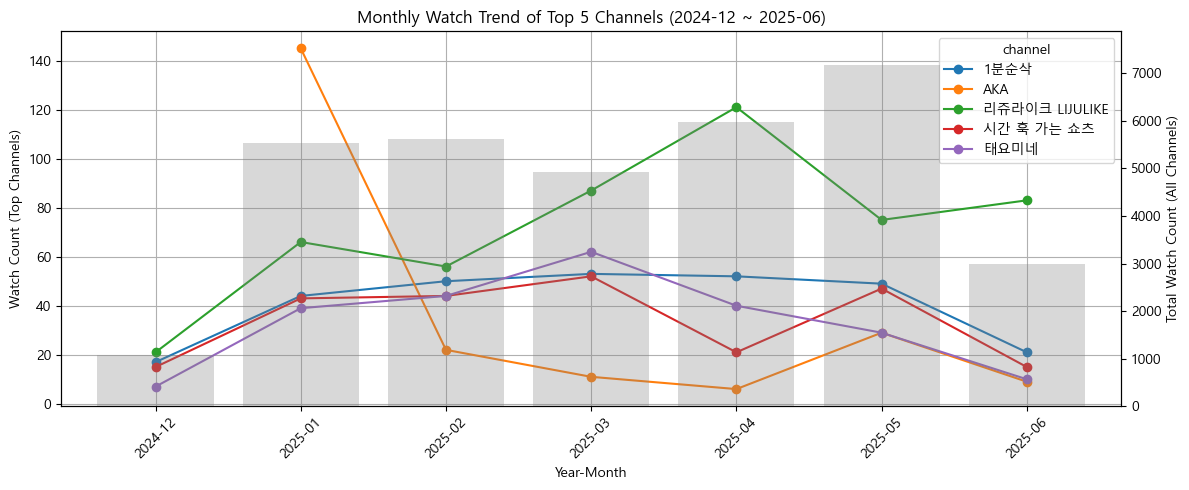

In [5]:
# 시청 시간 datetime으로 변환
df['time'] = pd.to_datetime(df['time'], errors='coerce')

# 채널명 추출
df['channel'] = df['subtitles'].apply(lambda x: x[0]['name'] if isinstance(x, list) else None)
df = df.dropna(subset=['time'])


# 날짜/요일/시간 파생 컬럼
df['weekday'] = df['time'].dt.day_name()
df['hour'] = df['time'].dt.hour
df['date'] = df['time'].dt.date

df = df.dropna(subset=['hour'])

# 막대그래프로 시각화하기

# Showing as 2024.0 --> fixation

df['year_month'] = df['time'].dt.to_period('M').astype(str) # e.g., "2024-12"

start_date = df['year_month'].min()
end_date= df['year_month'].max()

# Group data
df['year_month'] = df['time'].dt.to_period('M').astype(str)
df['year'] = df['time'].dt.year

top_n_channels = df['channel'].value_counts().head(5).index.tolist()

# Pivoted channel-wise trend
trend = (
    df[df['channel'].isin(top_n_channels)]
    .groupby(['year_month', 'channel']).size()
    .reset_index(name='count')
    .pivot(index='year_month', columns='channel', values='count')
)

# Total monthly watch count
monthly_total = df['year_month'].value_counts().sort_index()

# Plot
fig, ax1 = plt.subplots(figsize=(12, 5))

# Line plot: top 5 channels
trend.plot(kind='line', marker='o', ax=ax1)
ax1.set_xlabel("Year-Month")
ax1.set_ylabel("Watch Count (Top Channels)")
ax1.set_title(f"Monthly Watch Trend of Top 5 Channels ({df['year_month'].min()} ~ {df['year_month'].max()})")
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True)

# Bar plot: total watch count
ax2 = ax1.twinx()
monthly_total.plot(kind='bar', color='gray', alpha=0.3, ax=ax2, width=0.8)
ax2.set_ylabel("Total Watch Count (All Channels)")
ax2.set_ylim(0, monthly_total.max() * 1.1)  # Adjust bar scale for visibility

plt.tight_layout()
plt.show()



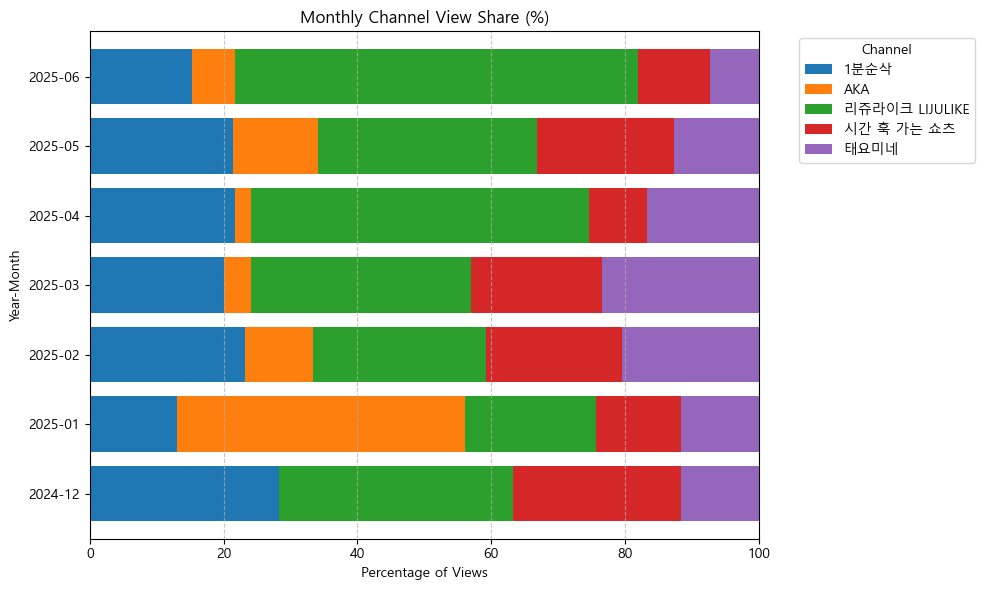

In [6]:
import matplotlib.pyplot as plt

# 1. 숫자형 데이터 추출
trend_numeric = trend.select_dtypes(include='number')

# 2. 열 이름 정리
trend_numeric.columns = trend_numeric.columns.astype(str).str.strip()

# 3. 퍼센트 계산
total_watched_times = trend_numeric.sum(axis=1)
percent_df = trend_numeric.divide(total_watched_times, axis=0) * 100
percent_df.index = percent_df.index.astype(str)

# 4. 색깔 지정
custom_colors = {
    '1분순삭': '#1f77b4',           # 파랑
    'AKA': '#ff7f0e',              # 주황
    '리쥬라이크 LIJULIKE': '#2ca02c',  # 초록
    '시간 훅 가는 쇼츠': '#d62728',    # 빨강
    '태요미네': '#9467bd'            # 보라
}
color_list = [custom_colors[col] for col in percent_df.columns]

# 5. 시각화
percent_df.plot(
    kind='barh',
    stacked=True,
    figsize=(10, 6),
    width=0.8,
    color=color_list
)

plt.xlim(0, 100)
plt.xlabel('Percentage of Views')
plt.ylabel('Year-Month')
plt.title('Monthly Channel View Share (%)')
plt.legend(title='Channel', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()



In [7]:
years = top_channels_by_year['year'].unique()
for year in years:
    subset = top_channels_by_year[top_channels_by_year['year'] == year]
    plt.figure(figsize=(10, 5))
    sns.barplot(data=subset, x='count', y='channel', palette='viridis')
    plt.title(f"Top 10 Most Watched Channels in {year}")
    plt.xlabel("Watch Count")
    plt.ylabel("Channel")
    plt.tight_layout()
    plt.show()

NameError: name 'top_channels_by_year' is not defined

In [ ]:
# 시청 시간 datetime으로 변환
df['time'] = pd.to_datetime(df['time'], errors='coerce')

# 채널명 추출
df['channel'] = df['subtitles'].apply(lambda x: x[0]['name'] if isinstance(x, list) else None)

# 요일/시간 파생 컬럼
df['weekday'] = df['time'].dt.day_name()
df['hour'] = df['time'].dt.hour


# 시간대 숫자 정수로 바꾸기
df['hour'] = df['hour'].astype(int)


In [ ]:
# Choose top N channels overall
top_n_channels = df['channel'].value_counts().head(5).index.tolist()

# Filter data for just those channels
df['year'] = df['time'].dt.year
filtered_df = df[df['channel'].isin(top_n_channels)]

# Group and pivot for line chart
trend = (
    filtered_df.groupby(['year', 'channel']).size()
    .reset_index(name='count')
    .pivot(index='year', columns='channel', values='count')
)

# Plot
trend.plot(kind='line', marker='o', figsize=(10, 5))
plt.title(f"Watch Trend of Top 5 Channels ({start_date} ~ {end_date})")
plt.xlabel("Year")
plt.ylabel("Watch Count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df.groupby('year_month').size().plot(kind='line')
plt.xticks(rotation=45)
plt.title("Monthly Trend")
plt.xlabel("Year-Month")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [ ]:
title = f"Most Watched time\n({start_date}~{end_date})"

df['hour'].value_counts().sort_index().plot(
    kind='bar',
    title=title,
    xlabel='Hour of Day',
    ylabel='Watch Count',
    figsize=(10,5)
)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
# 요일별 분석
title = f"Most Watched day\n({start_date}~{end_date})"

df['weekday'].value_counts().sort_index().plot(
    kind='bar',
    title=title,
    xlabel='Day',
    ylabel='Watch Count',
    figsize=(10,5)
)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
#연도별 시청 횟수
title = f"Watched Variance per Year\n({start_date} ~ {end_date})"

df['time'].dt.year.value_counts().sort_index().plot(
    kind='bar',
    title=title,
    xlabel='Year',
    ylabel='Watch Count',
    figsize=(10, 5)
)

plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
#월별 시청 변화
title = f"Watched Variance per Month\n({start_date} ~ {end_date})"

df['time'].dt.month.value_counts().sort_index().plot(
    kind='bar',
    title=title,
    xlabel='Month',
    ylabel='Watch Count',
    figsize=(10, 5)
)

plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
df['year_month'] = df['time'].dt.to_period('M')
df['year_month'].value_counts().sort_index().plot(kind='bar', figsize=(12,5))